*This notebook was created by Sergey Tomin (sergey.tomin@desy.de) for IPC seminar. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). October 2020.*

In [1]:
from ocelot import *
from ocelot.gui import *
import copy

initializing ocelot...


### Lattice: buch compressor

In [2]:
d = Drift(0.5)
# Quadrupoles 
qf = Quadrupole(l=0.2, k1=1, k2=2)
qd = Quadrupole(l=0.2, k1=-1, k2=-2)

# Bends
angle0 = 14*np.pi/180
b1 = SBend(l=0.5, angle=angle0, e2=angle0, eid='B1')
b2 = SBend(l=0.5, angle=-angle0, e1=-angle0, eid='B2')
b3 = SBend(l=0.5, angle=-angle0, e2=-angle0, eid='B3')
b4 = SBend(l=0.5, angle=angle0, e1=angle0, eid='B4')

m1 = Marker(eid="START")
m2 = Marker(eid="SCREEN")

chicane = (b1, d, b2, d, d, b3, d, b4)

fodo = (qf, d, qd, d)

cell = (m1, d, chicane, d, fodo, m2)

lat = MagneticLattice(cell, method={"global": SecondTM})

### Twiss parameters

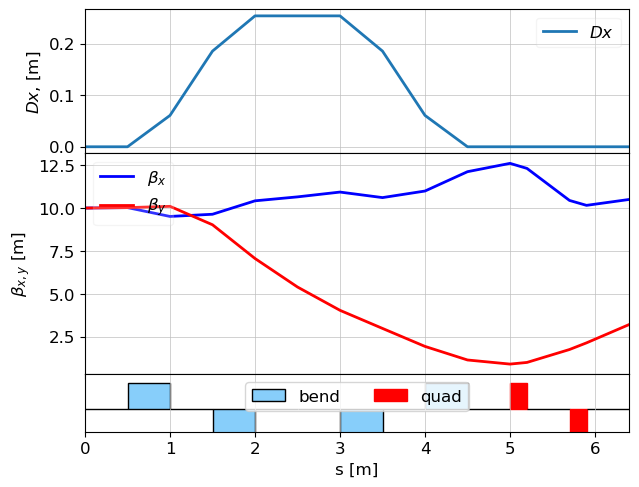

In [3]:
tws0 = Twiss()
tws0.beta_x = 10
tws0.beta_y = 10
tws0.alpha_x = 0
tws0.alpha_y = 0
tws0.E = 100e-3

tws = twiss(lat, tws0)

plot_opt_func(lat, tws)
plt.show()

In [4]:
R = lattice_transfer_map(lat, energy=100e-3)
print(R[4,5])

-0.10311173034412162


### Generate the electron beam -  ParticleArray

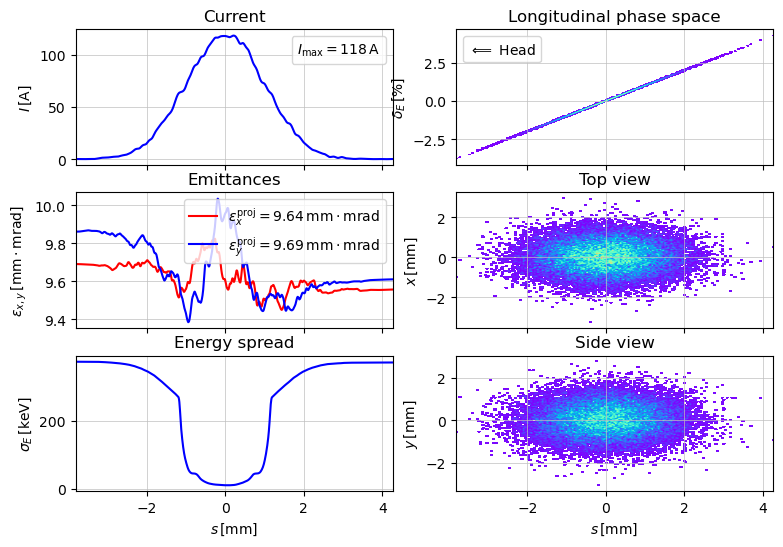

In [5]:
p_array_init = generate_parray(sigma_x=1e-3, sigma_px=5e-5, chirp=0.01,
                               nparticles=20000, charge=1e-09, energy=tws0.E, tws=tws0)

show_e_beam(p_array_init, figsize=(9,6))
plt.show()

### Track the beam through the lattice

z = 6.4 / 6.4. Applied: 

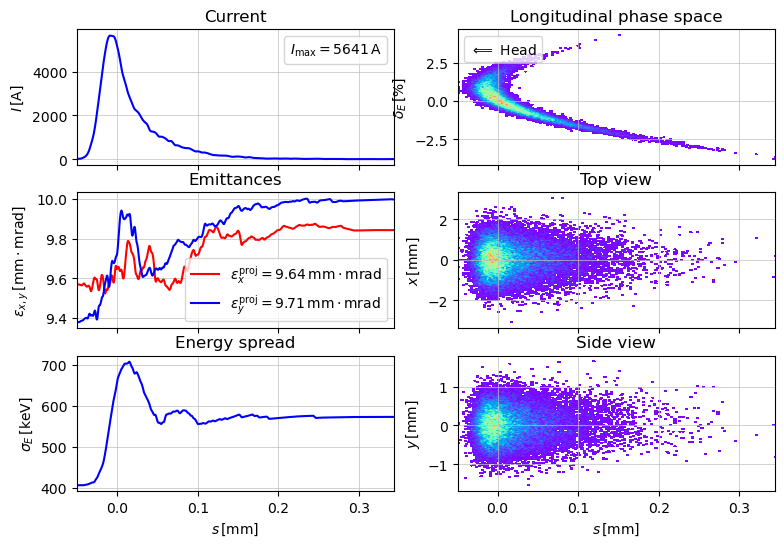

In [6]:
p_array = copy.deepcopy(p_array_init)

navi = Navigator(lat)

#navi.unit_step = 0.1
#csr = CSR()
#csr.sigma_min = 4e-6
#navi.add_physics_proc(csr, m1, m2)

tws_track, _ = track(lat, p_array, navi)

show_e_beam(p_array, figsize=(9,6))
plt.show()

### What does the screen show?

std(x) = 719.0758746359667 um; std(y) = 399.0834500527979 um;


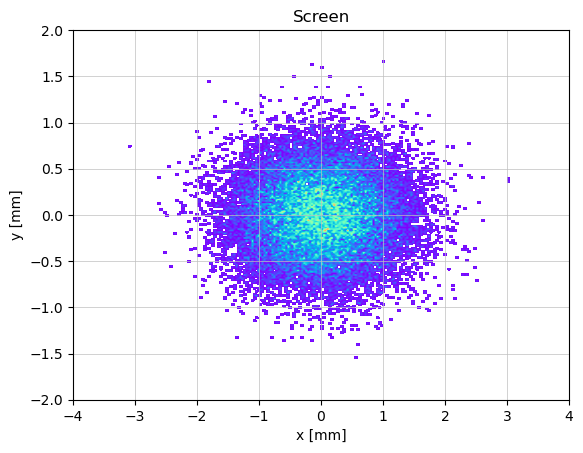

In [7]:
show_density(p_array.x()* 1e3, p_array.y() * 1e3, 
             xlabel="x [mm]", ylabel='y [mm]', title="Screen", limits=[(-4, 4), (-2, 2)])

print(f"std(x) = {np.std(p_array.x()) * 1e6} um; std(y) = {np.std(p_array.y()) * 1e6} um;")

### What if we have not identical dipoles?

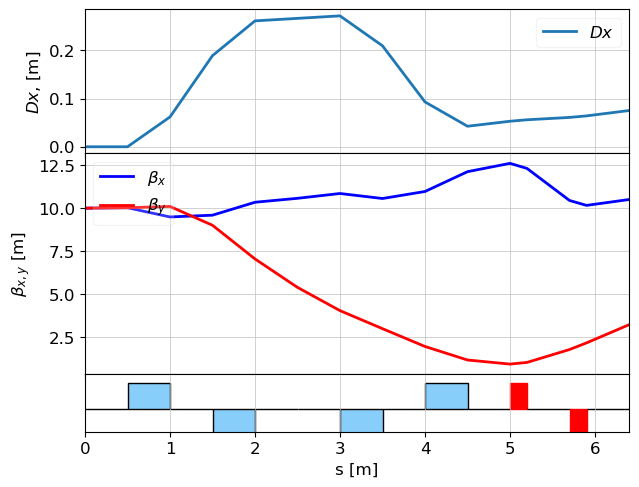

In [8]:
p_array = copy.deepcopy(p_array_init)

b1.angle = angle0 * (1 + .02)
b2.angle = -angle0 * (1 - .02)
b3.angle = -angle0 * (1 - .02)
b4.angle = angle0 * (1 + .02)
lat.update_transfer_maps()

tws = twiss(lat, tws0)
plot_opt_func(lat, tws, legend=False)
plt.show()

### Has the beam size on the screen changed? 

z = 6.4 / 6.4. Applied: std(x) = 1037.9069892477612 um; std(y) = 398.90408947079084 um;


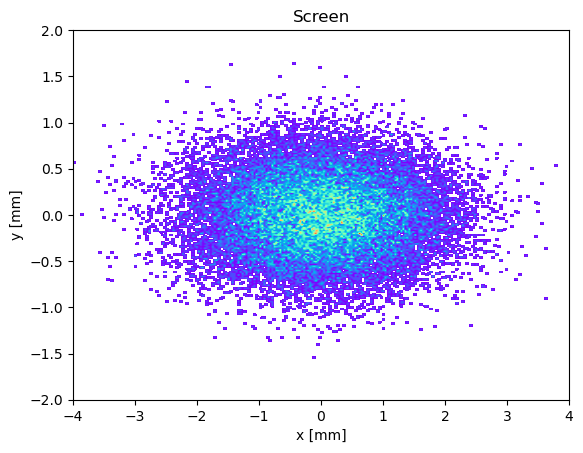

In [9]:
navi = Navigator(lat)
tws_track, _ = track(lat, p_array, navi)
print(f"std(x) = {np.std(p_array.x()) * 1e6} um; std(y) = {np.std(p_array.y()) * 1e6} um;")

show_density(p_array.x()* 1e3, p_array.y() * 1e3, 
             xlabel="x [mm]", ylabel='y [mm]', title="Screen", limits=[(-4, 4), (-2, 2)], grid=False)

### Let's minimize the horizontal beam size (dispersion?) on the screen with two last dipoles.

In [10]:
from scipy.optimize import minimize

# Our objective function 
def get_beam_size(angles):
    p_array = copy.deepcopy(p_array_init)

    b3.angle = angles[0]
    b4.angle = angles[1]
    lat.update_transfer_maps()
    
    # NOTE: for simplicity, we do not take into account changes in the drift length between dipoles B3 and B4.

    navi = Navigator(lat)
    # navi.unit_step = 0.1
    # csr = CSR()
    # csr.sigma_min = 4e-6
    # navi.add_physics_proc(csr, m1, m2)
    tws_track, _ = track(lat, p_array, navi)
    return np.std(p_array.x()) 

angles = np.copy([b3.angle, b4.angle])
print(f"init: angles = {angles}")

res = minimize(fun=get_beam_size, x0=angles)

print()
print(f"res: angles = {res['x']}")

init: angles = [-0.23945917  0.24923302]
z = 6.4 / 6.4. Applied: 
res: angles = [-0.43648764  0.50760325]


z = 6.4 / 6.4. Applied: std(x) = 162.60623447637025 um; std(y) = 492.3983116819463 um;


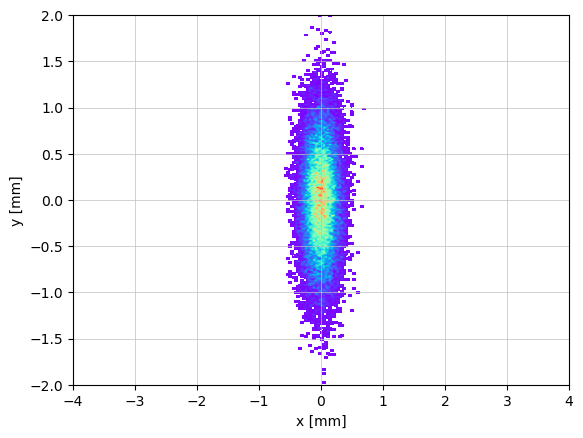

In [11]:
p_array = copy.deepcopy(p_array_init)

navi = Navigator(lat)
tws_track, _ = track(lat, p_array, navi)

show_density(p_array.x()*1e3, p_array.y()*1e3, xlabel="x [mm]", ylabel='y [mm]', limits=[(-4, 4), (-2, 2)])
print(f"std(x) = {np.std(p_array.x()) * 1e6} um; std(y) = {np.std(p_array.y()) * 1e6} um;")

### What is going on? Let's have a look to the twiss parameters

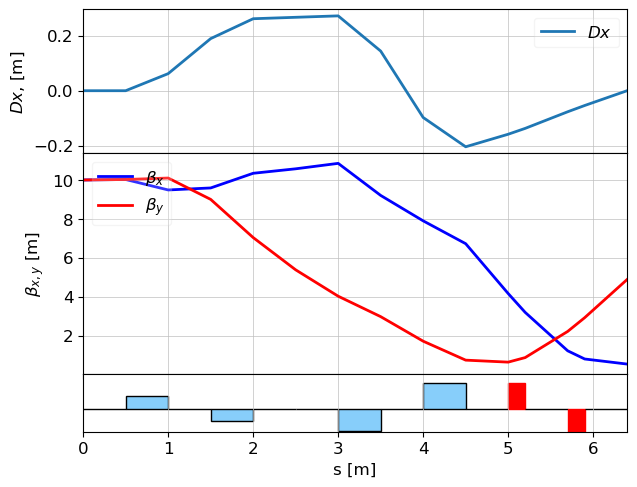

In [12]:
tws = twiss(lat, tws0)
plot_opt_func(lat, tws, legend=False)
plt.show()

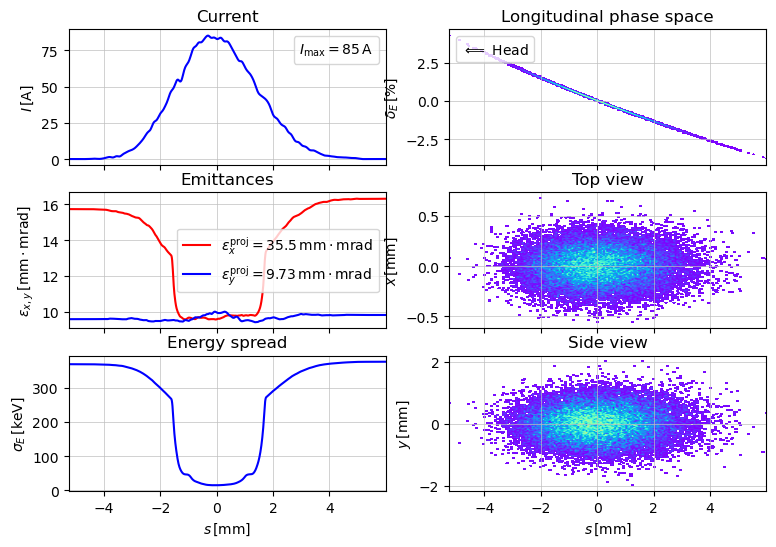

In [13]:
show_e_beam(p_array, figsize=(9,6))
plt.show()

In [14]:
R = lattice_transfer_map(lat, energy=100e-3)
print("R56 = ", R[4,5])

R56 =  -0.24092917476178766
